# Lending Case Study


## Problem Statement: 
Identify the 5 driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.



In [98]:
# Filtering Warnings
import warnings
warnings.filterwarnings('ignore')

#Other Python library's
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_columns', 1000) #Setting column display limit
pd.set_option('display.max_rows', 9000) #Setting column display limit
import re
plt.style.use('ggplot') #Applying style to graphs
from sklearn.impute import KNNImputer

# Data File Importing

In [194]:
data=pd.read_csv("/Users/apple/Downloads/UpGrad/EDA/Case Study/loan.csv") # Data file importing
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    id                              int64  
 1    member_id                       int64  
 2    loan_amnt                       int64  
 3    funded_amnt                     int64  
 4    funded_amnt_inv                 float64
 5    term                            object 
 6    int_rate                        object 
 7    installment                     float64
 8    grade                           object 
 9    sub_grade                       object 
 10   emp_title                       object 
 11   emp_length                      object 
 12   home_ownership                  object 
 13   annual_inc                      float64
 14   verification_status             object 
 15   issue_d                         object 
 16   loan_status                     object 
 17   pymnt_plan

In [195]:
data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade                 emp_title emp_length  \
0   10.65%       162.87     B        B2                       NaN  10+ years   
1   15.27%        59.83     C        C4                     Ryder   < 1 year   
2   15.96%        84.33     C        C5                       NaN  10+ years   
3   13.49%       339.31     C        C1       AIR RESOURCES BOARD  10+ years   
4   12.69%        67.79     B        B5  University Medical Group     1 year   

  home_ownership  annual_inc verification_status issue_d  loan_status  \
0           RENT     24000.0            Verified  Dec-11   Fully Paid   
1           RENT     30000.0     Source Verified  Dec-11  Charged Off   
2           RENT     12252.0        Not Verified  Dec-11   Fully Paid   
3           RENT     49200.0     Source Verified  Dec-11   Fully Paid   
4           RENT     80000.0     Source Verified  Dec-11      Current   

  pymnt_plan                                                url  \
0          n  https://lendingclub.com/browse/loanDetail.acti...   
1          n  https://lendingclub.com/browse/loanDetail.acti...   
2          n  https://lendingclub.com/browse/loanDetail.acti...   
3          n  https://lendingclub.com/browse/loanDetail.acti...   
4          n  https://lendingclub.com/browse/loanDetail.acti...   

                                                desc         purpose  \
0    Borrower added on 12/22/11 > I need to upgra...     credit_card   
1    Borrower added on 12/22/11 > I plan to use t...             car   
2                                                NaN  small_business   
3    Borrower added on 12/21/11 > to pay for prop...           other   
4    Borrower added on 12/21/11 > I plan on combi...           other   

                  title zip_code addr_state    dti  delinq_2yrs  \
0              Computer    860xx         AZ  27.65            0   
1                  bike    309xx         GA   1.00            0   
2  real estate business    606xx         IL   8.72            0   
3              personel    917xx         CA  20.00            0   
4              Personal    972xx         OR  17.94            0   

  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0           Jan-85               1                     NaN   
1           Apr-99               5                     NaN   
2           Nov-01               2                     NaN   
3           Feb-96               1                    35.0   
4           Jan-96               0                    38.0   

   mths_since_last_record  open_acc  pub_rec  revol_bal revol_util  total_acc  \
0                     NaN         3        0      13648     83.70%          9   
1                     NaN         3        0       1687      9.40%          4   
2                     NaN         2        0       2956     98.50%         10   
3                     NaN        10        0       5598        21%         37   
4                     NaN        15        0      27783     53.90%         38   

  initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
0                   f       0.00           0.00   5863.155187   
1                   f       0.00           0.00   1008.710000   
2                   f       0.00           0.00   3005.666844   
3                   f       0.00           0.00  12231.890000   
4                   f     524.06         524.06   3513.330000   

   total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0          5833.84          5000.00         863.16     

# Imortant variables considered based on the awareness from live seession conducted on 5th Mar 2023. 

In [199]:
# Imortant variables idetified based on the awareness from live seession conducted on 5th Mar 2023. 
data=data[['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','grade','sub_grade','annual_inc','dti','emp_length','purpose','loan_status','issue_d','home_ownership','verification_status']]
data = data[~(data.loan_status=='Current')] # Deleted the entries currently paying the loan
data=data[-(data.emp_length.isna())] # Deleted the entries with 'NaN' as the percentage of missing values is 2.7 only.

# Data cleaning to seperate the string and numeric values in the variables of interest

In [200]:
data['term'] = data['term'].str.extract('(\d+)').astype('int')
#data['int_rate'] = data['int_rate'].str.rstrip('%')
data['int_rate'] = data['int_rate'].str.extract('([^%]+)').astype('float') #removal of ''% symbol from intrest rate colum

#data['issue_month'] = data['issue_d'].str.extract('([a-zA-Z]+)')   
data['issue_year'] = data['issue_d'].str.extract('([0-9]+)')       # Derived Year Columns  
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')  # Derived Month Columns
data['issue_month']=data['issue_d'].dt.month                       

data=data.drop(['issue_d'], axis=1)
#data['loan_status'] = np.where(data['loan_status']=='Fully Paid', 1 , 0) # Decided to use if required

In [201]:
#data['emp_length'].fillna('0',inplace=True) # Replacing null with '0' as the percentage of missing values is 2.7% only.
data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype('int')

In [202]:
# convert numeric columns into numeric data for correlation.

cols = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','annual_inc','dti','emp_length','issue_year','issue_month']
data[cols] = data[cols].apply(pd.to_numeric)
data.dtypes

loan_amnt                int64
funded_amnt              int64
funded_amnt_inv        float64
term                     int64
int_rate               float64
grade                   object
sub_grade               object
annual_inc             float64
dti                    float64
emp_length               int64
purpose                 object
loan_status             object
home_ownership          object
verification_status     object
issue_year               int64
issue_month              int64
dtype: object

In [104]:
# Lets take a look on important variable loan status in total loans issued
(data.loan_status.value_counts()*100)/len(data)

Fully Paid     85.61954
Charged Off    14.38046
Name: loan_status, dtype: float64

# Observations

(1) 85.6 percent loans were fully paid.<br>
(2) 15% loans were charged off

# Univariate Analysis

In [105]:
data['loan_amnt'].describe()

count    37544.000000
mean     11119.329986
std       7354.098954
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

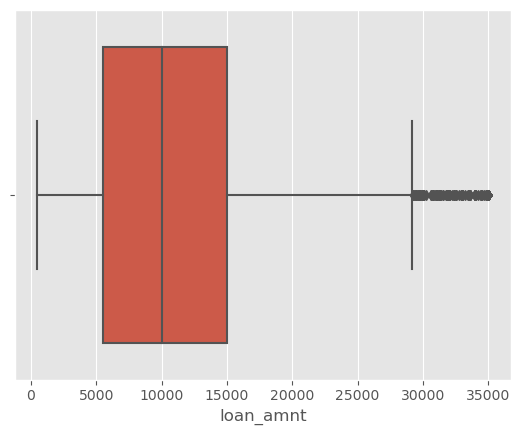

In [106]:
sns.boxplot(data.loan_amnt)
plt.show

In [107]:
data.annual_inc.describe()

count    3.754400e+04
mean     6.940708e+04
std      6.467698e+04
min      4.000000e+03
25%      4.100000e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

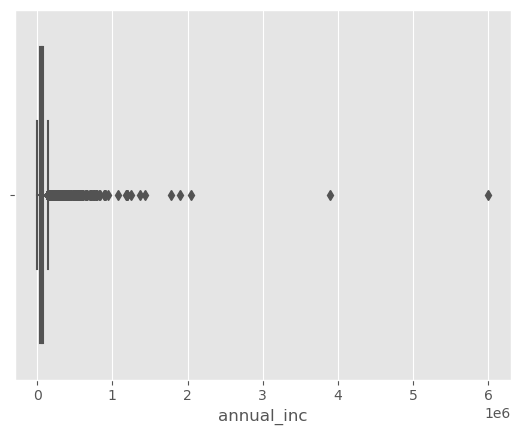

In [108]:
sns.boxplot(data.annual_inc)
plt.show()

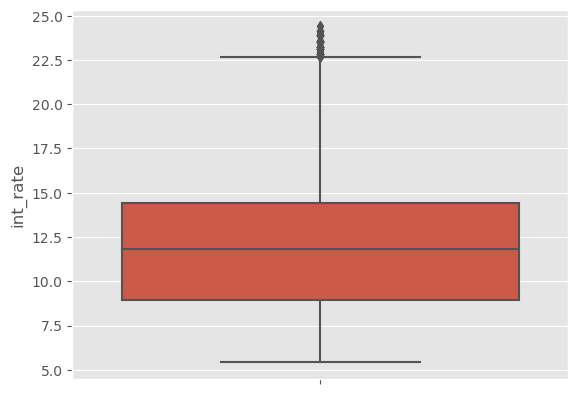

In [109]:
sns.boxplot(y=data.int_rate)
plt.show()

# Removing of Outliers in annual_inc

In [110]:
data = data[data["annual_inc"] < data["annual_inc"].quantile(0.99)]
data.annual_inc.describe()

count     37165.000000
mean      65903.070210
std       35153.363496
min        4000.000000
25%       40906.000000
50%       59000.000000
75%       81600.000000
max      234996.000000
Name: annual_inc, dtype: float64

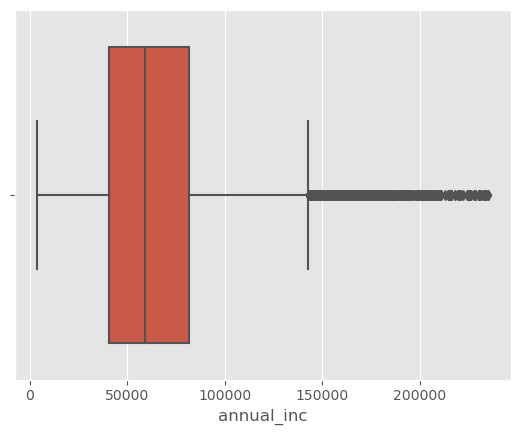

In [111]:
sns.boxplot(data.annual_inc)
plt.show()

# Correlation using Heatmap

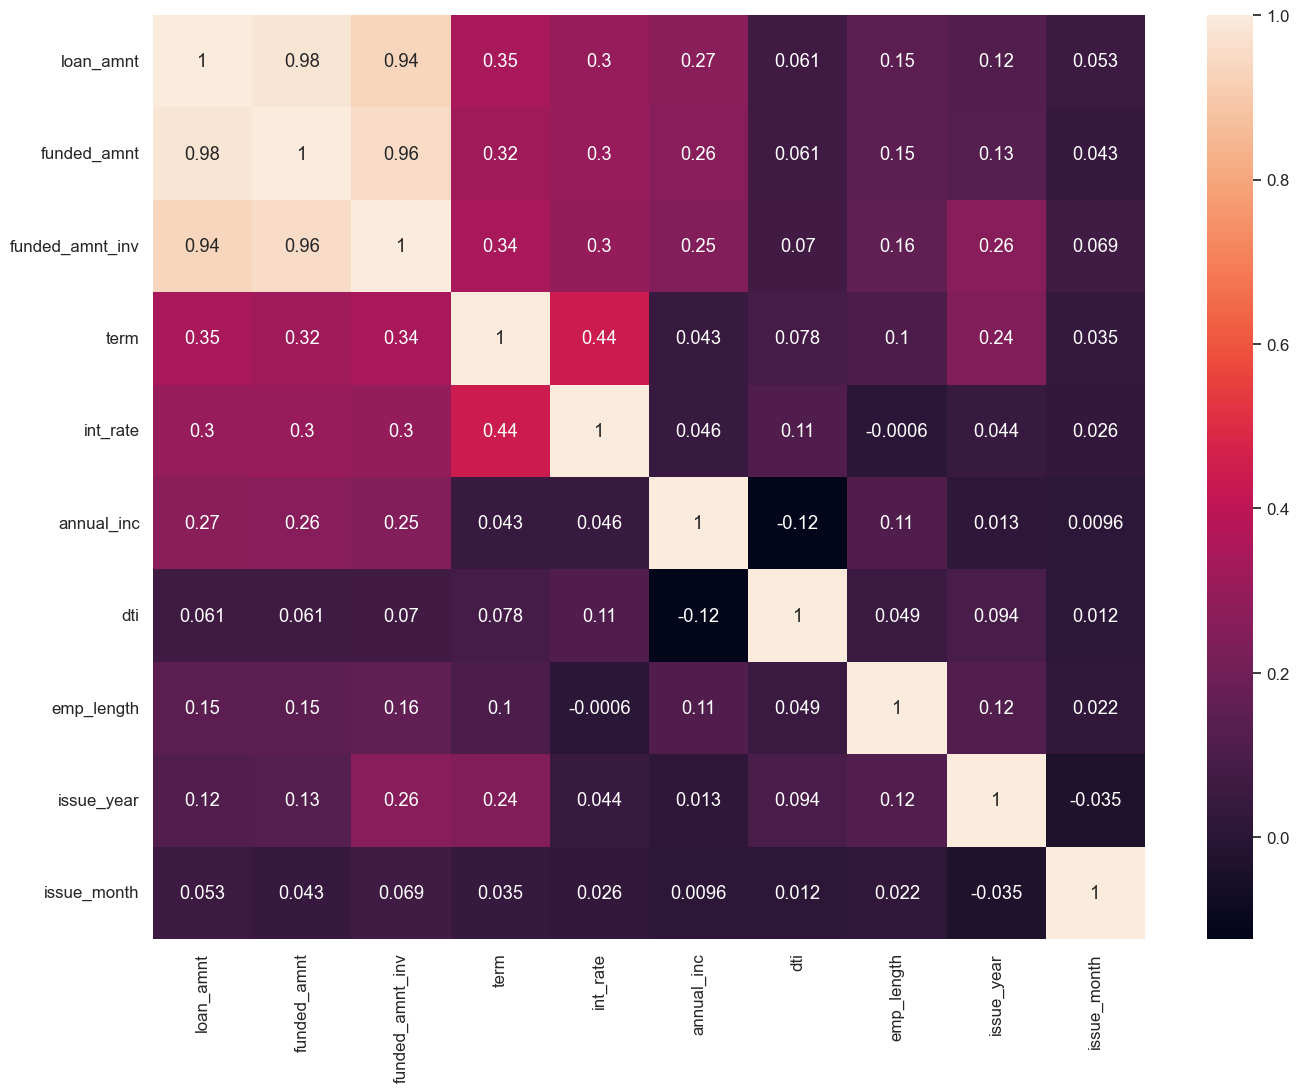

In [203]:
plt.figure(figsize=(16,12))
sns.set(font_scale=1.1)
sns.heatmap(data.corr(),annot=True,)
plt.show()

# Observations from Correlation:

(1) Observation is that Loan amount, investor amount, funding amount are strongly correlated.<br>
(2) Annual income and Interest rate is positively correlated.<br>
(3) Annual income with dti is negatively correlated.<br>
(4) Term and Interest Rate is positively correlated.<br>
(5) Annual Income and Employment length (Years) is positively correlated.

# Understand the outliers using Boxplot

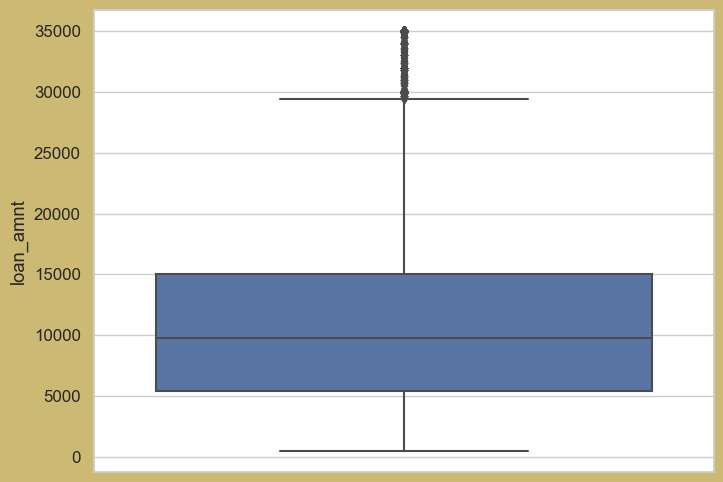

In [113]:
plt.figure(figsize=(8,6),facecolor='y')
sns.set_style("whitegrid")
#sns.set_style("dark")
sns.boxplot(y=data['loan_amnt'])
plt.show()

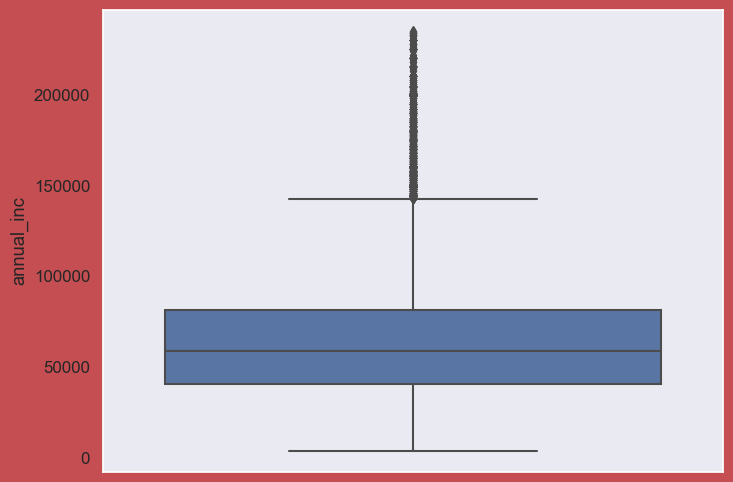

In [114]:
plt.figure(figsize=(8,6),facecolor='r')
sns.set_style("dark")
sns.boxplot(y=data['annual_inc'])
plt.show()

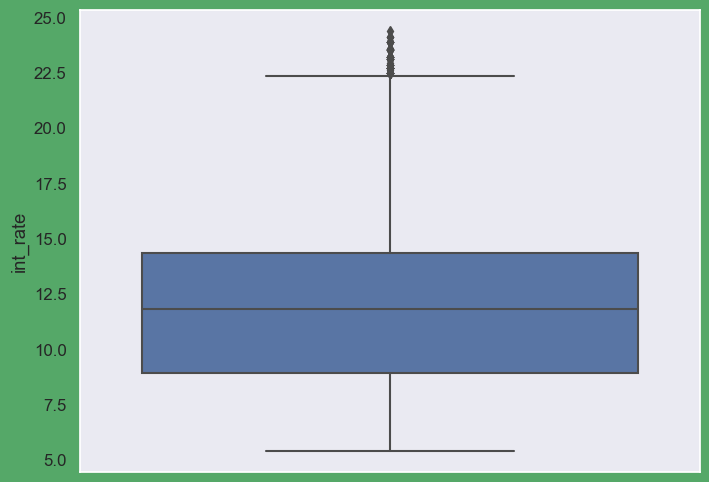

In [115]:
plt.figure(figsize=(8,6),facecolor='g')
sns.set_style("dark")
sns.boxplot(y=data['int_rate'])
plt.show()

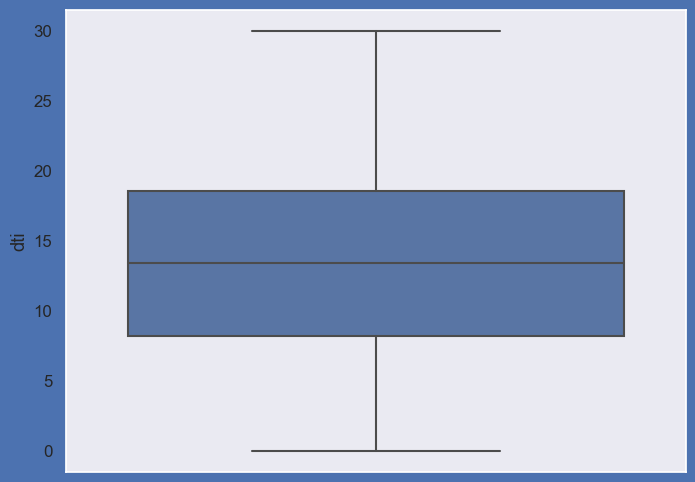

In [116]:
plt.figure(figsize=(8,6),facecolor='b')
sns.set_style("dark")
sns.boxplot(y=data['dti'])
plt.show()

# Understand the distribution in loan Amount, Funded Amount, Funded Amount by Investor

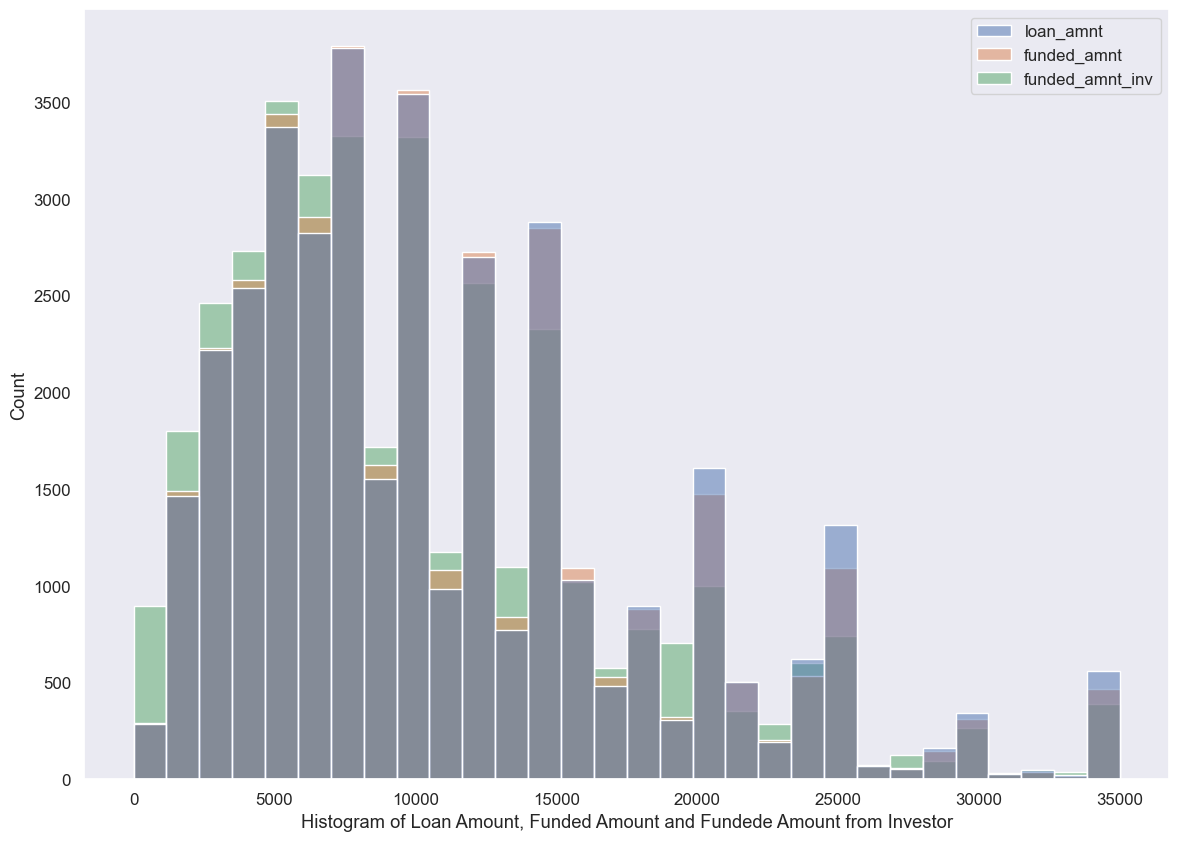

In [163]:
plt.figure(figsize=(14,10))
sns.histplot((data.loan_amnt, data.funded_amnt, data.funded_amnt_inv), bins=30)
plt.xlabel("Histogram of Loan Amount, Funded Amount and Fundede Amount from Investor")
plt.show()

# Observation

(1) Distribution of amounts for all three looks very much similar.<br>
(2) So instead of considering three different variables. <br>
(3) As a best distribution we shall go with single variable i.e.,"Loan Amount" only.

# Univariate Analysis - Unordered Categorical Variables

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64

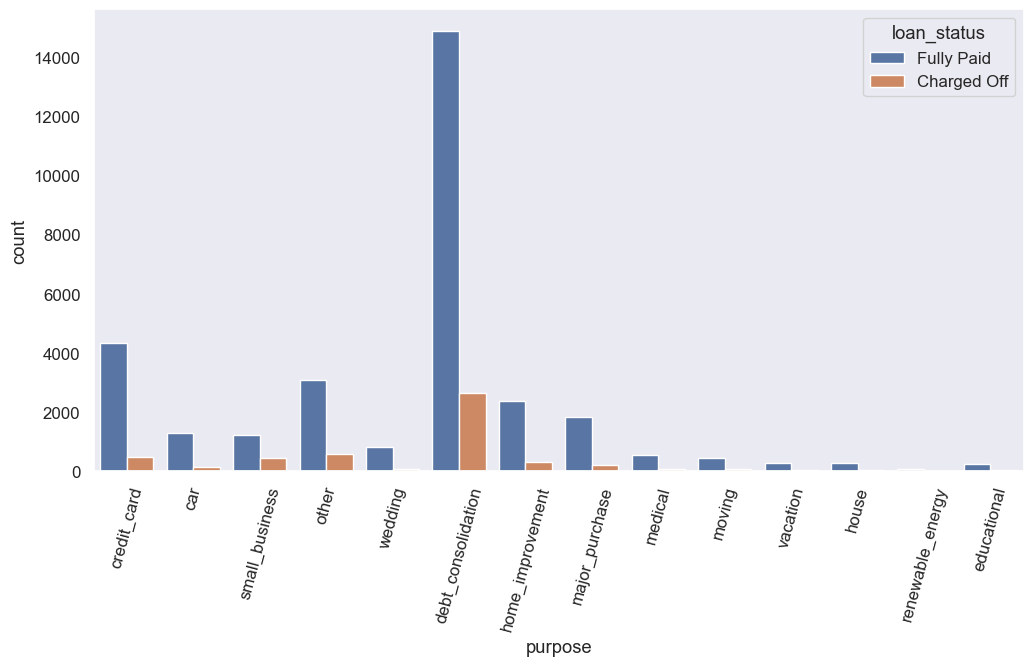

In [118]:
plt.figure(figsize=(12,6))
sns.countplot(x=data['purpose'], data=data, hue='loan_status')
plt.xticks(rotation=75)
data.loan_status.value_counts()

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64

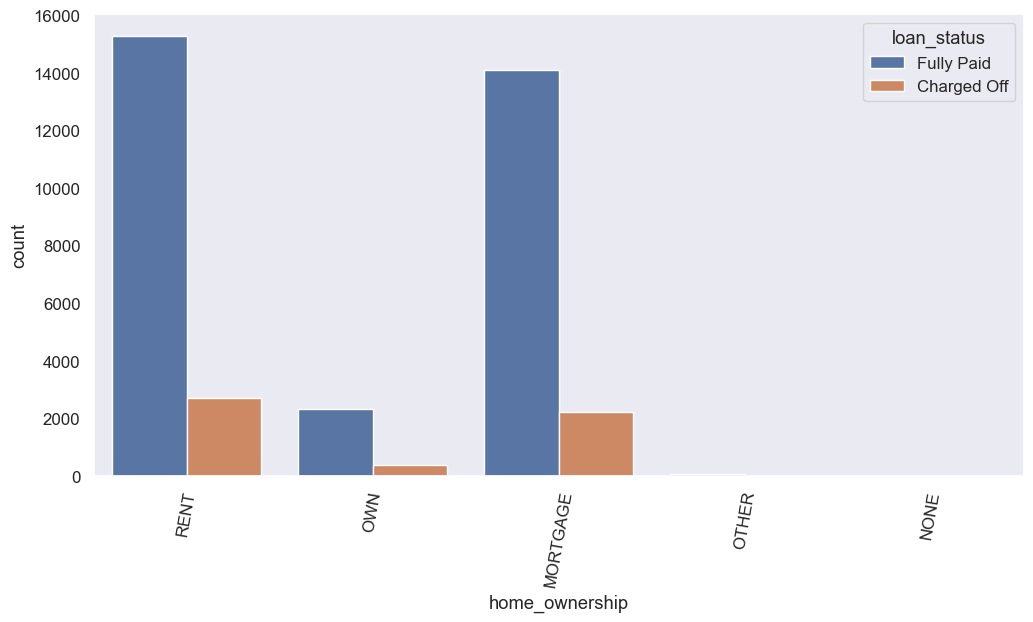

In [119]:
plt.figure(figsize=(12,6))
sns.countplot(x="home_ownership",data=data,hue='loan_status')
plt.xticks(rotation=80)
data.loan_status.value_counts()

# Observations from Univariate Analysis - Unordered Categorical Variable

(1) Most of the loans were taken for the purpose of debt consolidation followed by paying credit card bill. Also, charged off count is high for debt consolidation followed by paying credit card bill.<br>
(2) Most of the loans taken for the home ownership falls under rent and mortgage. Also, charged off count is high for rent and mortgage.

# Univariate Analysis - Ordered Categorical Variables

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64

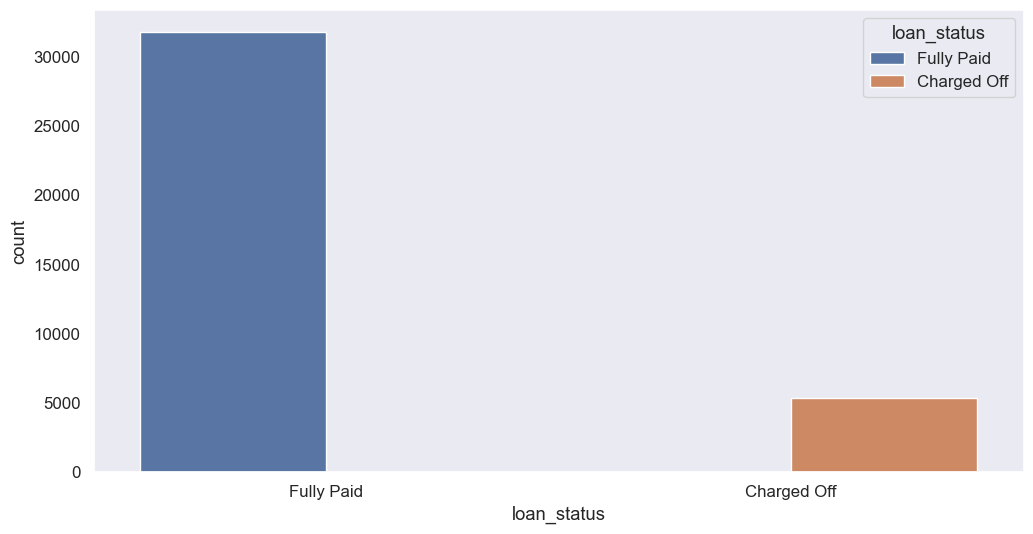

In [184]:
plt.figure(figsize=(12,6))
sns.countplot(x='loan_status', data=data, hue='loan_status')
plt.xticks(rotation=0)
data.loan_status.value_counts()

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64

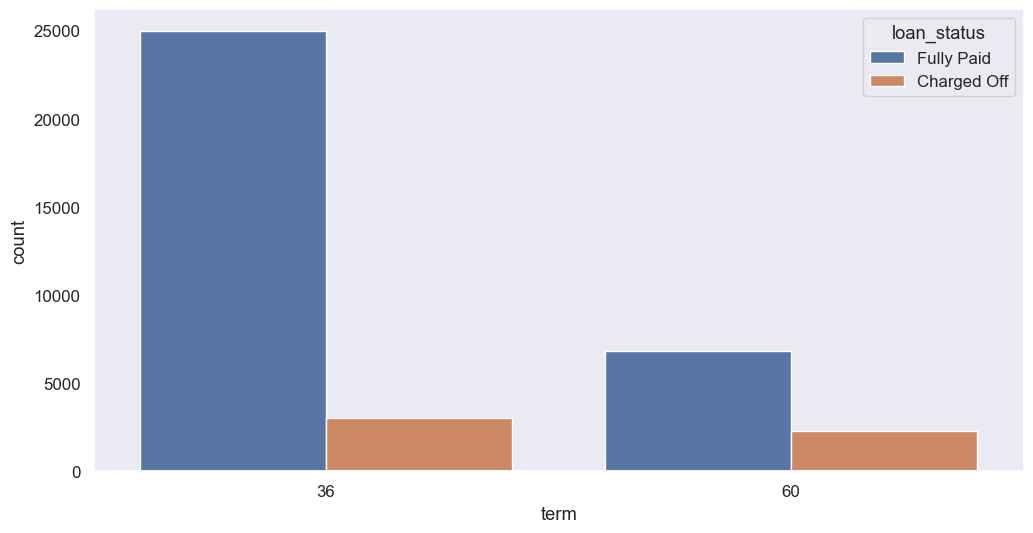

In [123]:
plt.figure(figsize=(12,6))
sns.countplot(x="term",data=data,hue='loan_status')
plt.xticks(rotation=0)
data.loan_status.value_counts()

# Observation

Considering the volume of applications for 36 ad 60 month sterm, the applicants taken loan for 60 months had more % of getting charged off as compared to applicants who had taken loan for 36 months.

# Derived Columns for Month and Year - Ordered Categorical Variables

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64

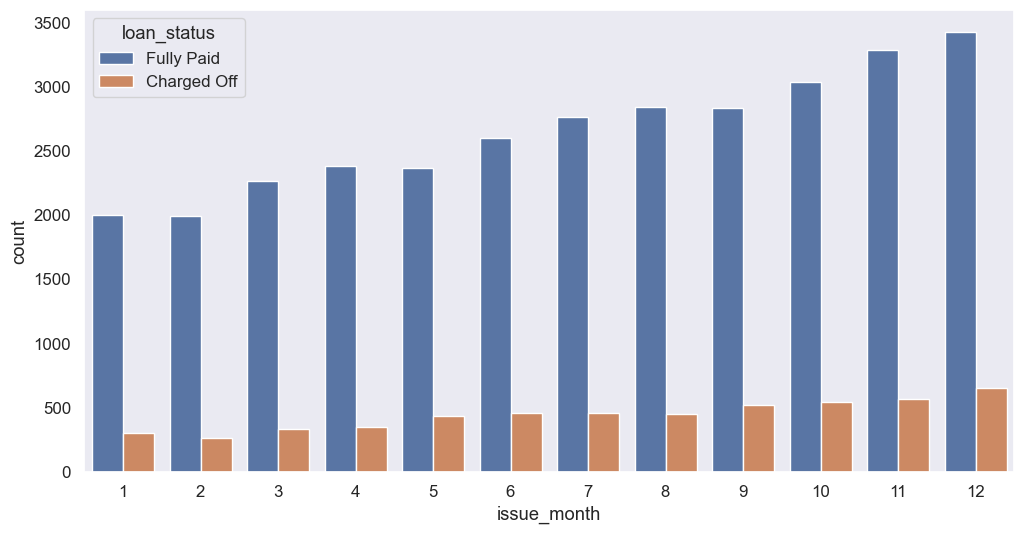

In [178]:
plt.figure(figsize=(12,6))
sns.countplot(x="issue_month",data=data,hue='loan_status')
plt.xticks(rotation=0)
data.loan_status.value_counts()

Fully Paid     31808
Charged Off     5357
Name: loan_status, dtype: int64

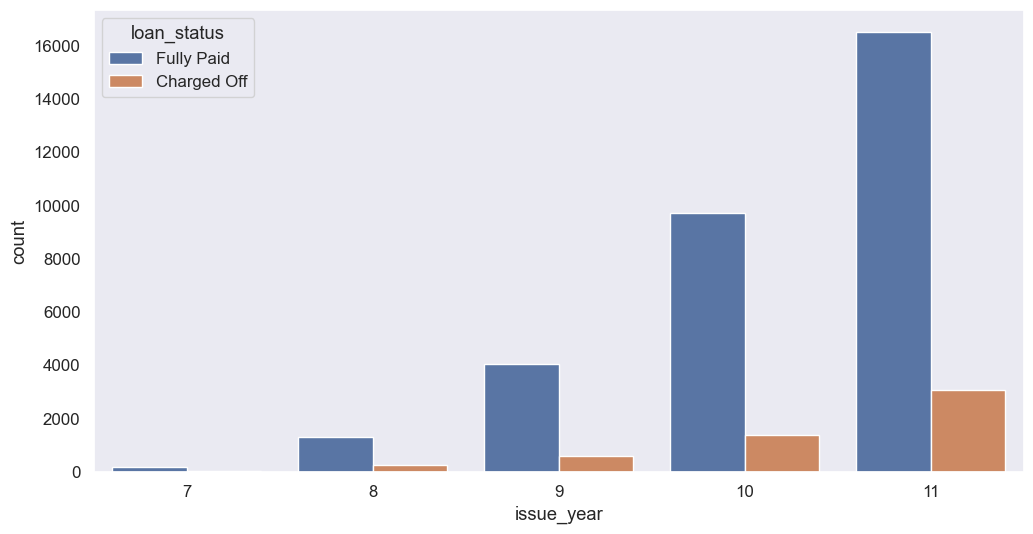

In [179]:
plt.figure(figsize=(12,6))
sns.countplot(x="issue_year",data=data,hue='loan_status')
plt.xticks(rotation=0)
data.loan_status.value_counts()

# Observations from Derived Variables

Observation is that with increase in loan applications every month and year, there is increase in charged off.

# Important Columns are grouped based on the "quantile" for the futher insights

In [124]:
ln_am=data.loan_amnt.quantile([.1, .25, .5, .75, 1.0])
an_inc=data.annual_inc.quantile([.1, .20, .4, .6, 0.8, 0.9])
in_rat=data.int_rate.quantile([.1, .25, .5, .75, 1.0])
dt=data.dti.quantile([.1, .25, .5, .75, 1.0])
print(ln_am,an_inc,in_rat,dt)

0.10     3200.0
0.25     5400.0
0.50     9800.0
0.75    15000.0
1.00    35000.0
Name: loan_amnt, dtype: float64 0.1     30000.0
0.2     38000.0
0.4     50400.0
0.6     65004.0
0.8     90000.0
0.9    112451.0
Name: annual_inc, dtype: float64 0.10     7.14
0.25     8.94
0.50    11.83
0.75    14.35
1.00    24.40
Name: int_rate, dtype: float64 0.10     4.15
0.25     8.24
0.50    13.45
0.75    18.60
1.00    29.99
Name: dti, dtype: float64


In [125]:
# categorise loan amounts into buckets which will help in analysis further in bivariate analysis.
data['loan_amnt_group'] = pd.cut(data['loan_amnt'], [0, 3200, 5400, 9800, 15000, 35000], labels=['0-3200', '3200-5400', '9800-15000', '15000-35000','35000 +'])

# categorise annual incomes into buckets which will help in analysis further in bivariate analysis.
data['annual_inc_group'] = pd.cut(data['annual_inc'], [0, 38000, 50400, 65000, 90000,111000], labels=['0-38000', '38000-50400', '65000-90000', '90000-111000', '111000 +'])

# categorise intrest rates into buckets which will help in analysis further in bivariate analysis.
data['int_rate_group'] = pd.cut(data['int_rate'], [0, 8.94, 11.83, 14.35, 24.40], labels=['0-8.94', '8.94-11.83', '11.71-14.35', '14.35+'])

# categorise dti into buckets for bivariate analysis.
data['dti_group'] = pd.cut(data['dti'], [0, 8.24, 13.45, 18.60, 29.99], labels=['0-8.24', '8.21-13.45', '13.43-18.60', '29.99+'])

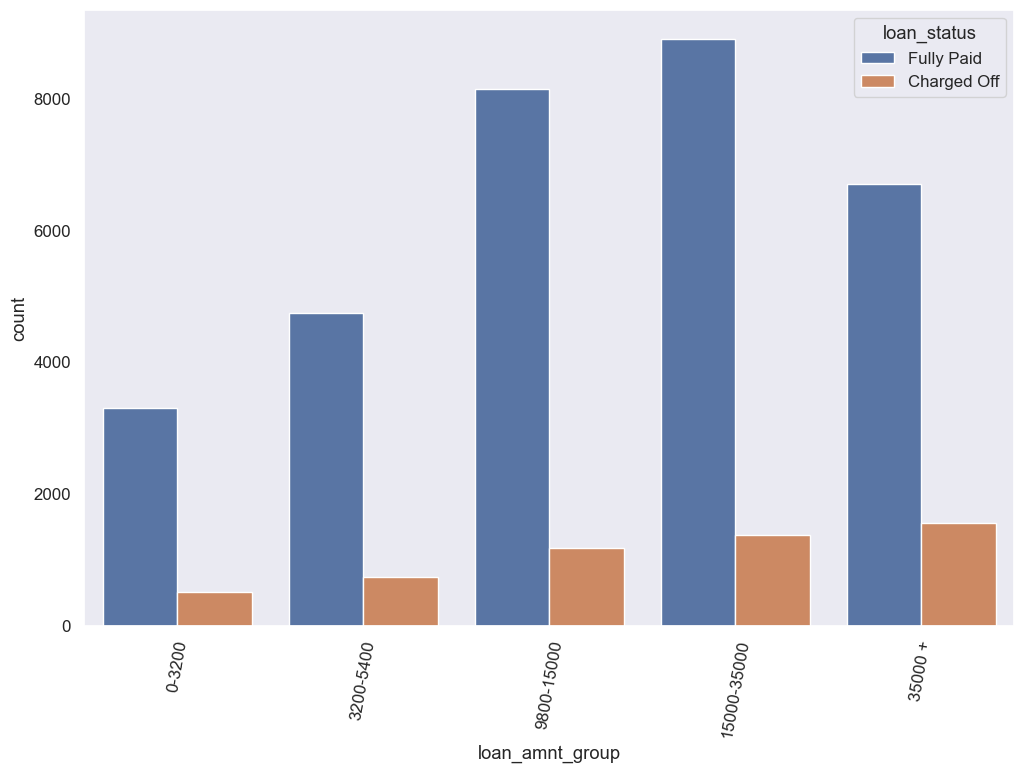

In [126]:
plt.figure(figsize=(12,8))
sns.countplot(x="loan_amnt_group",data=data,hue='loan_status')
plt.xticks(rotation=80)
plt.show()

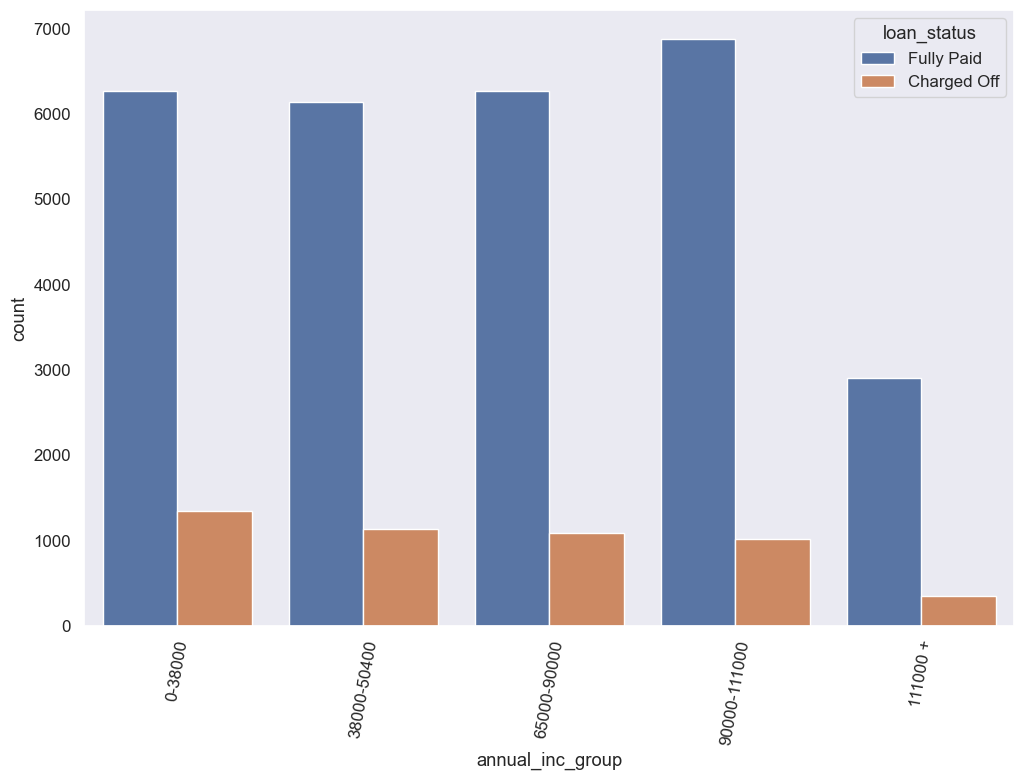

In [127]:
plt.figure(figsize=(12,8))
sns.countplot(x="annual_inc_group",data=data,hue='loan_status')
plt.xticks(rotation=80)
plt.show()

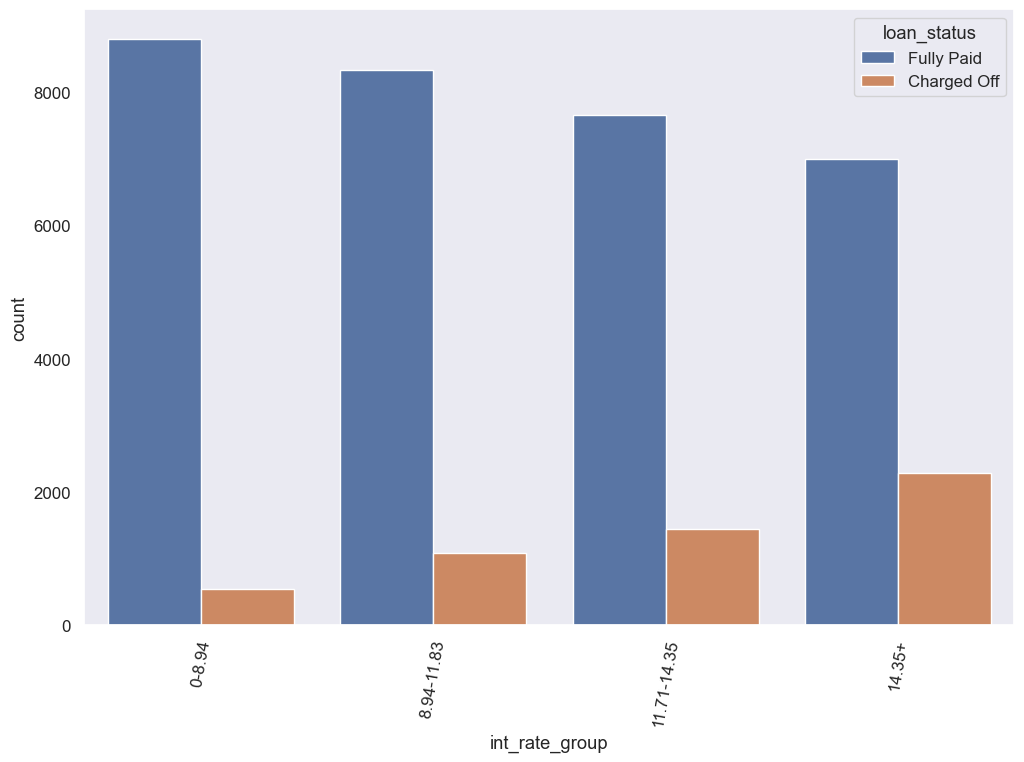

In [128]:
plt.figure(figsize=(12,8))
sns.countplot(x="int_rate_group",data=data,hue='loan_status')
plt.xticks(rotation=80)
plt.show()

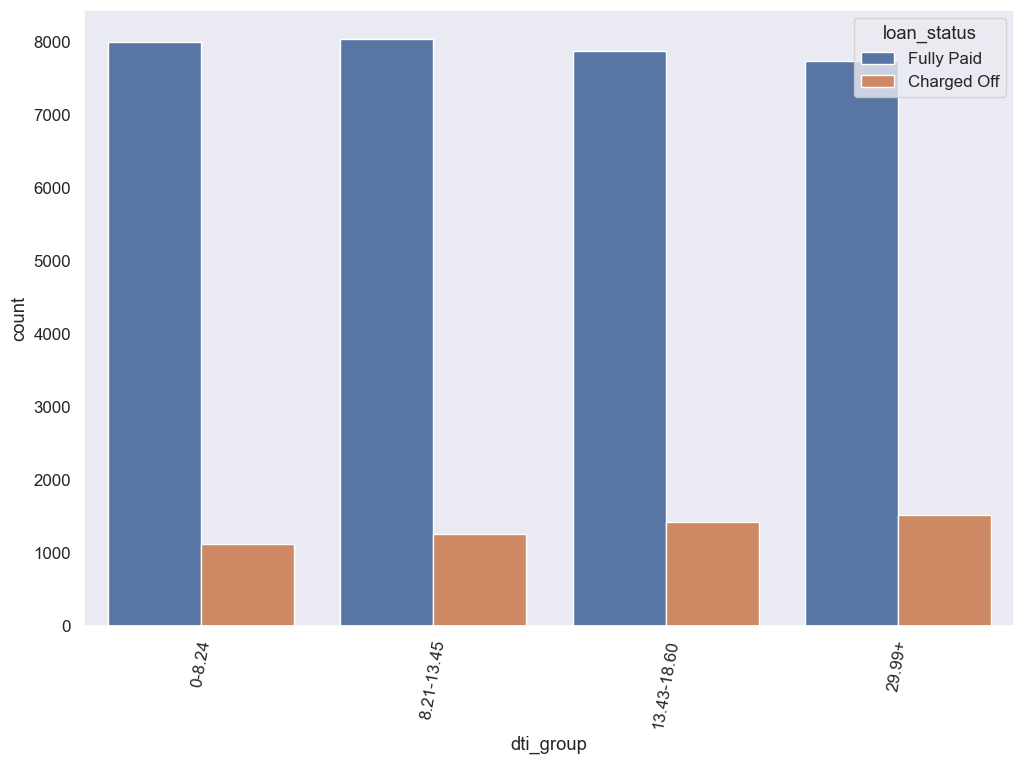

In [129]:
plt.figure(figsize=(12,8))
sns.countplot(x="dti_group",data=data,hue='loan_status')
plt.xticks(rotation=80)
plt.show()

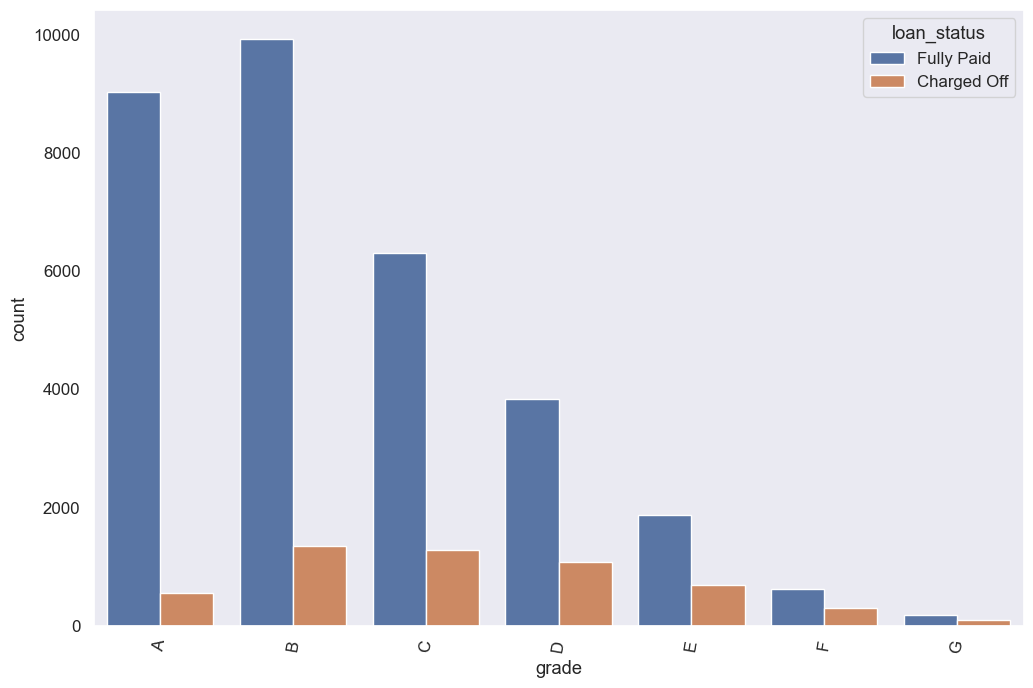

In [130]:
plt.figure(figsize=(12,8))
sns.countplot(x="grade",data=data.sort_values("grade"),hue='loan_status')
plt.xticks(rotation=80)
plt.show()

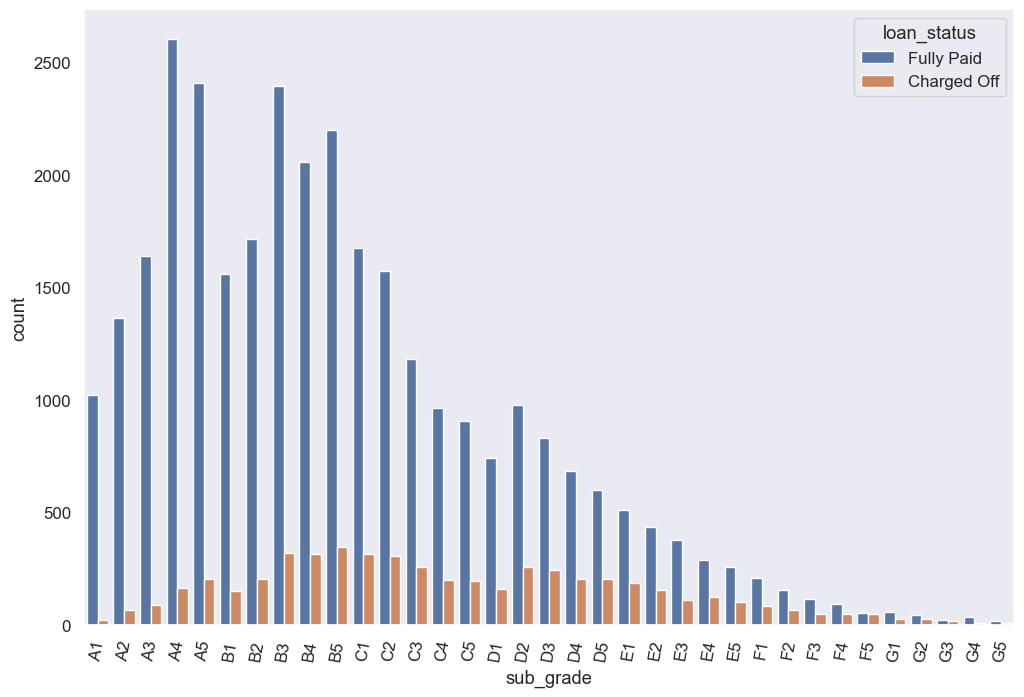

In [131]:
plt.figure(figsize=(12,8))
sns.countplot(x="sub_grade",data=data.sort_values("sub_grade"),hue='loan_status')
plt.xticks(rotation=80)
plt.show()

# Observations :

(1) With increase in loan amount there is increase in charged off.<br>
(2) With increase in annual income there is decrease in charged off.<br>
(3) With increase in intrest rate there is increase in charged off.<br>
(4) With increase in dti there is increase in charged off.<br>
(5) Grade B,C,D,E have high risk of charged off.<br>
(6) Grade B1:B5,C1:C5,D1:D5,E1:E5 have high risk of charged off.

# Bi-Variant Analysis

Text(0, 0.5, 'Loan Amount')

<Figure size 1200x800 with 0 Axes>

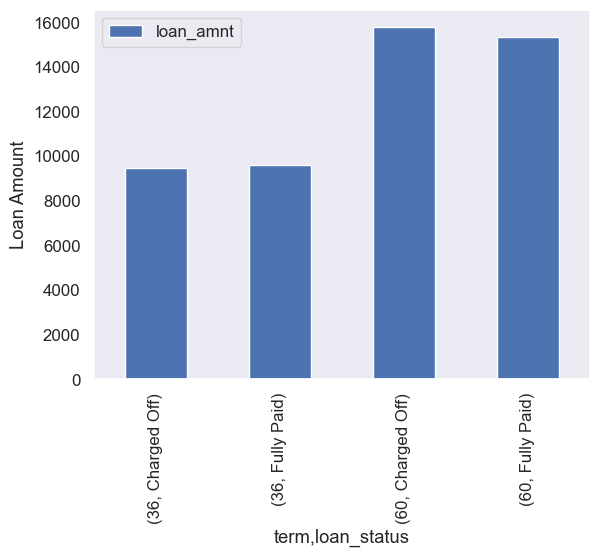

In [193]:
plt.figure(figsize=(12,8))
table = pd.pivot_table(data,index=['term','loan_status'],values=['loan_amnt'])
table.plot(kind='bar')
plt.ylabel('Loan Amount')

Text(0, 0.5, 'Employee Length')

<Figure size 1200x800 with 0 Axes>

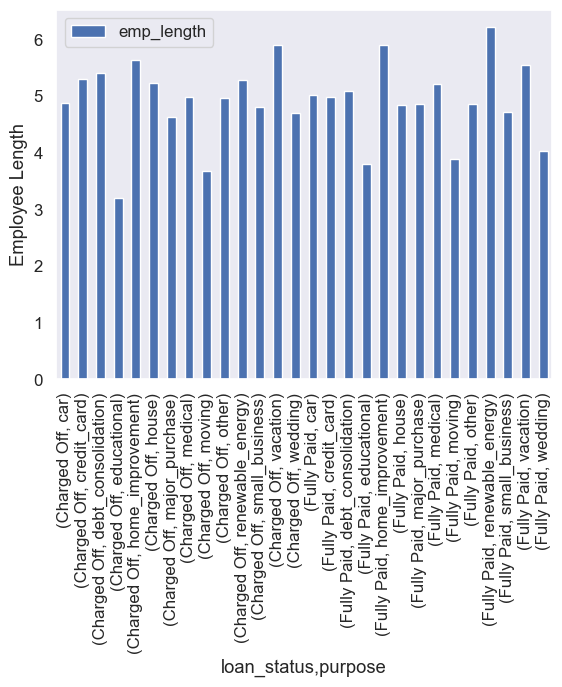

In [134]:
plt.figure(figsize=(12,8))
table = pd.pivot_table(data,index=['loan_status','purpose'],values=['emp_length'])
table.plot(kind='bar')
plt.ylabel('Employee Length')

Text(0, 0.5, 'Loan Amount')

<Figure size 1200x800 with 0 Axes>

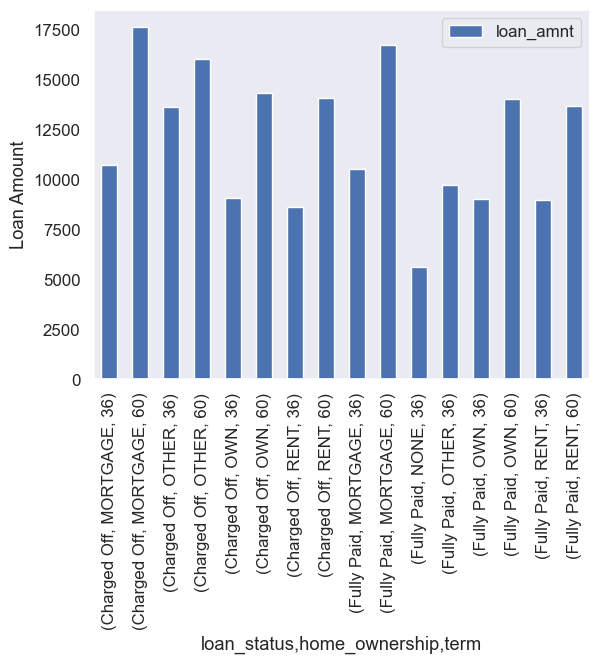

In [160]:
plt.figure(figsize=(12,8))
table = pd.pivot_table(data,index=['loan_status','home_ownership','term'],values=['loan_amnt'])
table.plot(kind='bar')
plt.ylabel('Loan Amount')

Text(0, 0.5, 'dti')

<Figure size 1200x800 with 0 Axes>

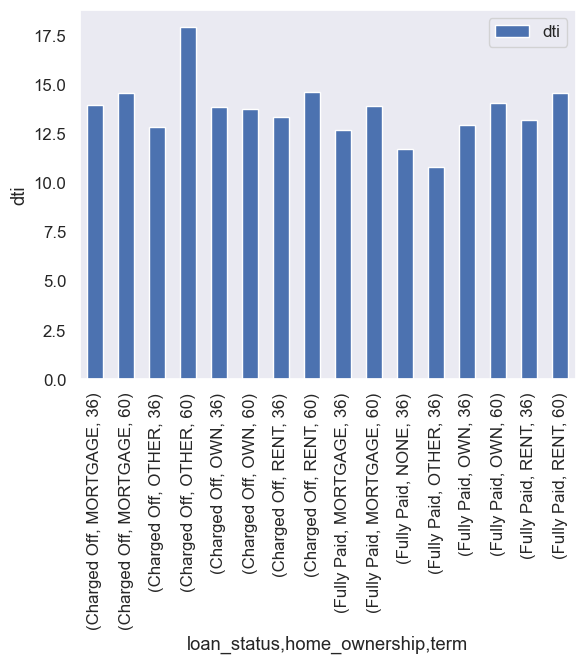

In [162]:
plt.figure(figsize=(12,8))
table = pd.pivot_table(data,index=['loan_status','home_ownership','term'],values=['dti'])
table.plot(kind='bar')
plt.ylabel('dti')

Text(0, 0.5, 'Annual Income, Loan Amount')

<Figure size 1200x800 with 0 Axes>

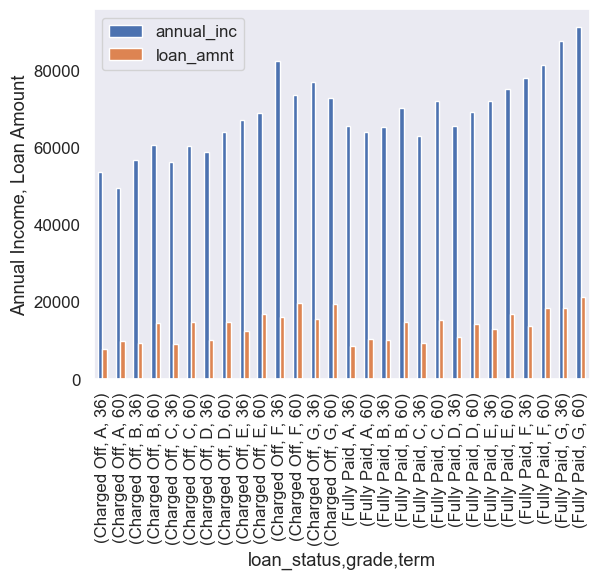

In [173]:
plt.figure(figsize=(12,8))
table = pd.pivot_table(data,index=['loan_status','grade','term'],values=['annual_inc','loan_amnt'])
table.plot(kind='bar')
plt.ylabel('Annual Income, Loan Amount')

# Conclusion from EDA using Univariant, Bi-variant, Numeric and Categorical Variables

(1) Considering the volume of applications for 36 and 60 month term, applicants taken loan for 60 months had more percentage of getting charged off as compared to applicants who had taken loan for 36 months.<br> 
(2) For vacation purpose, when high experienced employee applies for loan, there is a high risk of loan default. Similarly, when low experienced employee applies for education loan, there is risk of loan default.<br>
(3) Applicants taking loan for Mortgage under home ownership and 60 months term has high risk of default.<br>
(4) Applicants with high DTI, under OTHER in home ownership with 60 months term has high risk of default.<br>
(5) Grade F with high annual income choosing 60 months term has high risk of default.<br> 
(6) With increase in annual income there is decrease in charged off and with increase in interest rate there is increase in charged off.<br>
(7) Applicants living in rented home or mortgaged their home possess risk of loan default.<br>
(8) Loans taken for the purpose of debt consolidation followed by paying credit card bill possess risk of loan default.

# PairPlot considering important variable that can lead to loan default

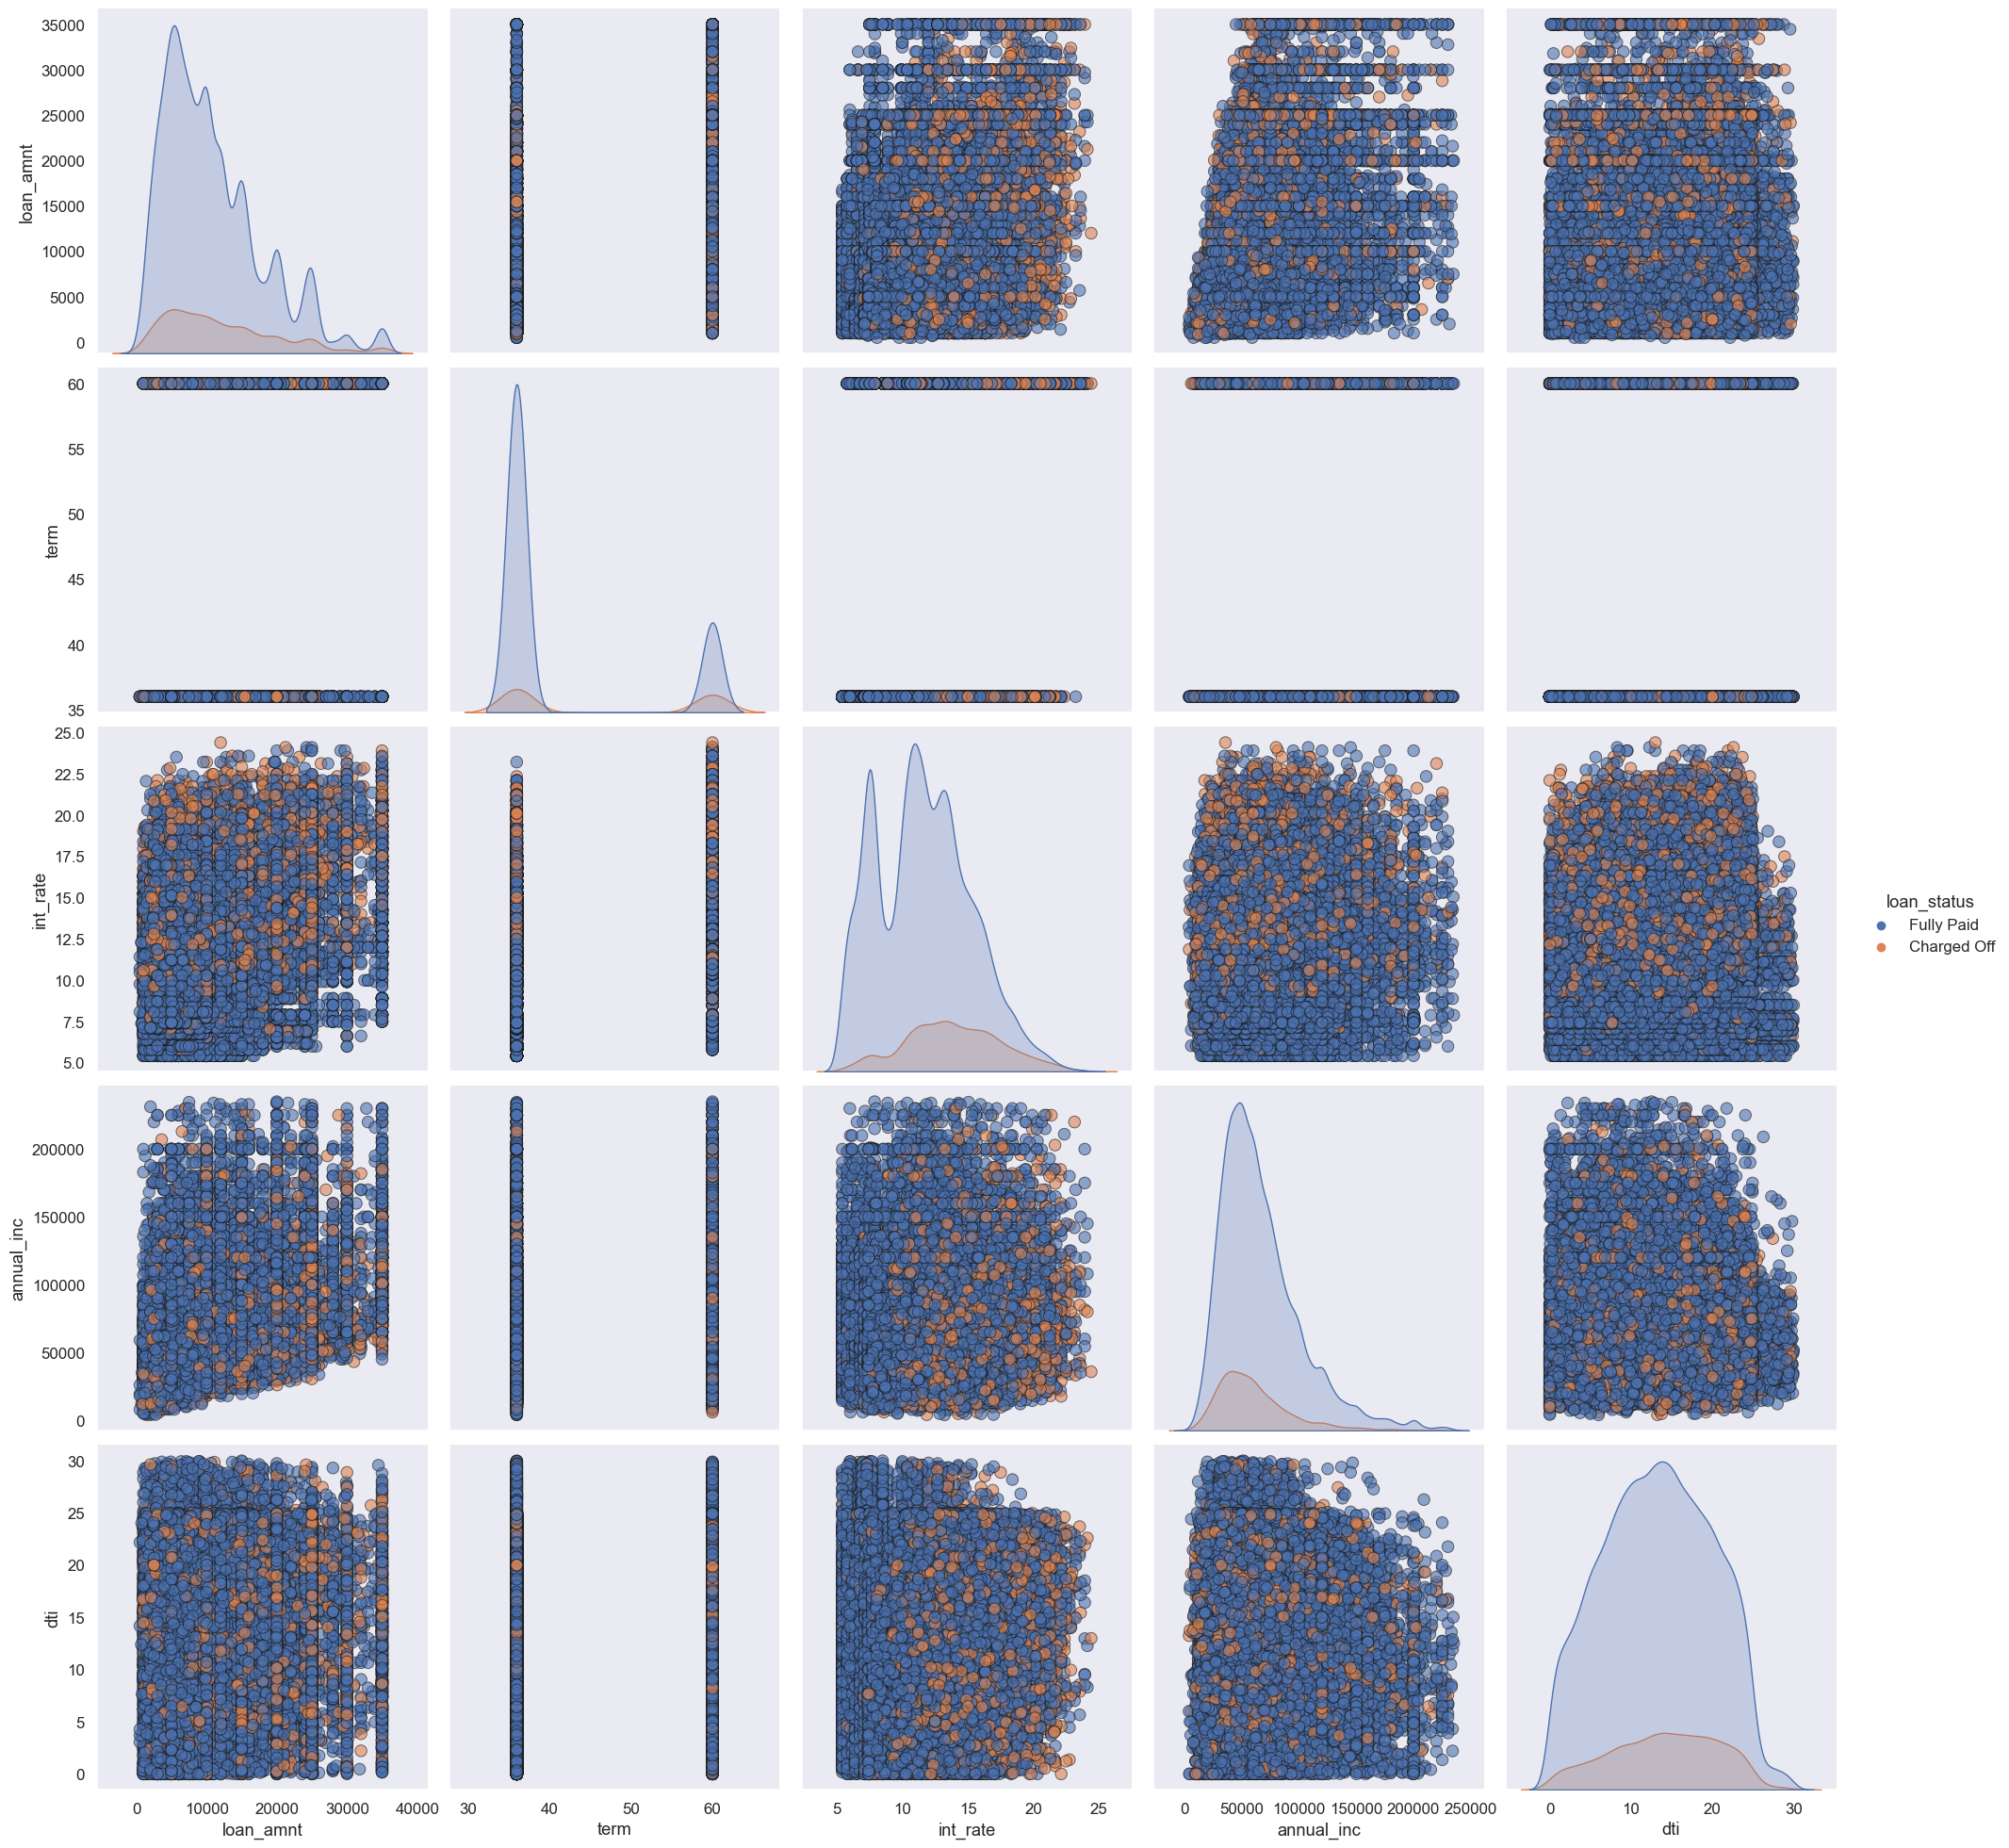

In [187]:
sns.pairplot(data[['loan_amnt','term','int_rate','annual_inc','dti','loan_status']], hue = 'loan_status', diag_kind = 'kde',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},size = 4)
plt.show()

# Observation from Pairplots:


(1) Higher the intrest rate higher charged off ratio.<br>
(2) Higher the annual income higher the loan amount,intrest rate & dti and vice-versa.<br>
(3) Intrest rate is increasing with increase in loan amount could lead to loan default.

# CONCLUSION

(1) Loans with 60 month term had more percentage of getting charged off.<br>
(2) Loan on vacation by experienced employee possess high risk of loan default.<br>
(3) Loan on mortgage with 60 months term has high risk of default.<br>
(4) Debit to income for unknown purpose by house owners with 60 months term has high risk of default.<br>
(5) Grade F with high annual income choosing 60 months term has high risk of default.<br>
(6) Loans taken for the purpose of debt consolidation possess risk of loan default.<br>
(7) With increase in annual income there is decrease in charged off and with increase in interest rate there is increase in charged off.<br>
(8) Applicants living in rented home or mortgage possess risk of loan default.